This notebook contains the code to generate the plots shown in the paper. It assumes the experiments were run as described on GitHub, and the result are stored in /experiments.

In [1]:
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

from omegaconf import OmegaConf

from SOC_eigf.experiment_settings.settings import define_variables
from SOC_eigf.utils import stochastic_trajectories, control_objective
from SOC_eigf.method import SOC_Solver

### Exact solution

In [2]:
cfg = OmegaConf.load('experiment_cfg.yaml')
cfg.setting = "OU_quadratic_stable"
cfg.d = 20
cfg.T = 3.0
cfg.num_steps=1000
cfg.optim.batch_size=128*16
ts = torch.linspace(0, cfg.T, cfg.num_steps + 1).to(cfg.device)
x0, sigma, optimal_sde, neural_sde = define_variables(cfg, ts)
optimal_sde.use_learned_control = False

In [3]:
state0 = x0.repeat(cfg.optim.batch_size, 1)
states,_,_,_,_,target_controls = stochastic_trajectories(
                            optimal_sde,
                            state0,
                            ts.to(state0),
                            cfg.lmbd,
                            detach=True)

<>:27: SyntaxWarning: invalid escape sequence '\|'
<>:27: SyntaxWarning: invalid escape sequence '\|'
/tmp/ipykernel_1053009/3280432965.py:27: SyntaxWarning: invalid escape sequence '\|'
  ax.set_ylabel('Control error $\|u-u^*\|^2$')


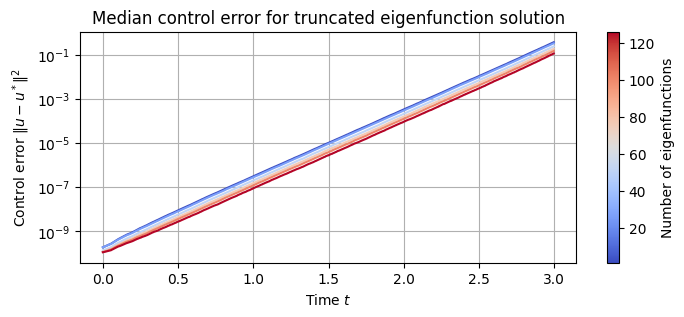

In [4]:
gs_controls = optimal_sde.exact_eigf_control(ts[:-1], states[:-1], 1)

fig, ax = plt.subplots(figsize=(8,3))
colormap_name = 'coolwarm'
colormap = plt.get_cmap(colormap_name)

max_k = 150
step = 25
ks = np.arange(1,max_k,step)
colors = [colormap(i / (len(ks) - 1)) for i in range(len(ks))]

# Normalize the color map to the range of ks
norm = mcolors.Normalize(vmin=ks.min(), vmax=ks.max())
sm = cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])  # Needed for the colorbar

for k in ks:
    color = colormap(norm(k))
    eigf_controls = optimal_sde.exact_eigf_control(ts[:-1], states[:-1], k, verbose=False)
    err = ((eigf_controls - target_controls)**2).sum(dim=2).median(dim=1).values.cpu()
    ax.plot(ts[:-1].cpu(), err, color=color)
    ax.set_yscale('log')

# Add colorbar
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Number of eigenfunctions')
ax.set_ylabel('Control error $\|u-u^*\|^2$')
ax.set_xlabel('Time $t$')
ax.set_title('Median control error for truncated eigenfunction solution')
ax.grid()
plt.show()

In [5]:
optimal_sde.exact_eigvals(2)

tensor([14.6410, 18.1051], device='cuda:0')

### Eigenfunction losses

In [6]:
experiment_name = "OU_stable_d20/EIGF"
run_names = ['var_GAUSS','ritz_GAUSS','pinn_GAUSS','rel_GAUSS']

In [7]:
dfs = []
for run_name in run_names:
    df = pd.read_csv(f'experiments/{experiment_name}/{run_name}/logs.csv')
    df.dropna(how='all', inplace=True)
    df['run_name'] = run_name
    df['time'] = df['iteration_time'].cumsum()
    df.ffill(inplace=True)
    dfs.append(df)

df = pd.concat(dfs)

EMA_halflife = 200
for column in df.columns:
    if 'error' in column or 'loss' in column:
        df[f'{column}_EMA'] = (
            df.groupby('run_name')[column]
            #.transform(lambda x: np.exp(x.apply(lambda x: np.log(x)).ewm(halflife=EMA_halflife, adjust=False).mean()))
            .transform(lambda x: x.ewm(halflife=EMA_halflife, adjust=False).mean())
        )

print(df.columns)

Index(['itr', 'iteration_time', 'loss', 'main_loss', 'orth_loss', 'es_loss',
       'es_main_loss', 'es_orth_loss', 'eigf_error', 'grad_log_eigf_error',
       'control_objective_mean', 'control_objective_std', 'control_l2_error',
       'run_name', 'time', 'loss_EMA', 'main_loss_EMA', 'orth_loss_EMA',
       'es_loss_EMA', 'es_main_loss_EMA', 'es_orth_loss_EMA', 'eigf_error_EMA',
       'grad_log_eigf_error_EMA', 'control_l2_error_EMA'],
      dtype='object')


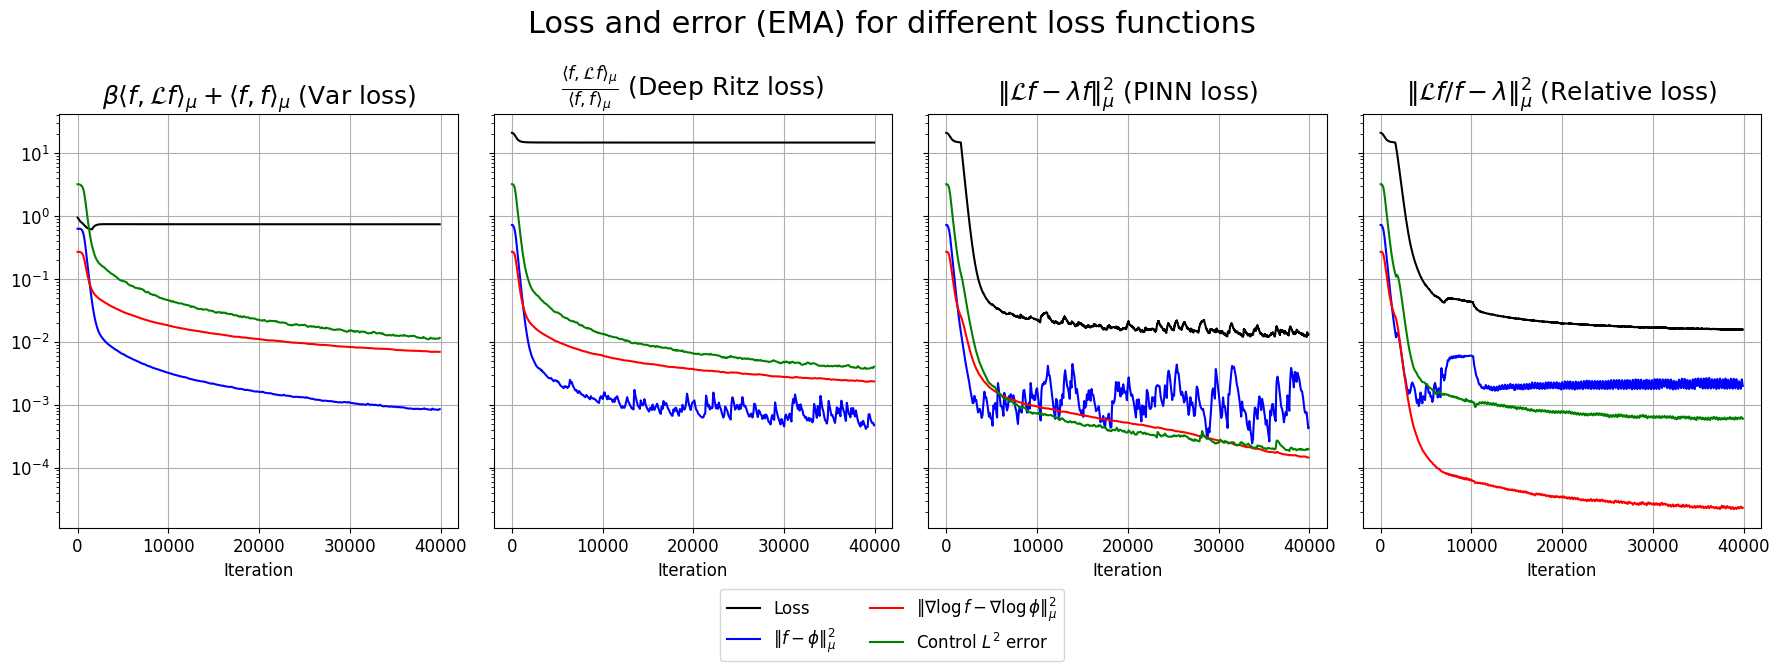

In [8]:
with plt.rc_context({'font.size': 12}):
    fig, axes = plt.subplots(1, len(run_names), figsize=(4.5*len(run_names),6),sharey=True,sharex=True)  # 1 row, 2 columns

    index = 'itr'
    col_appendix = "_EMA"
    labels = {
        'var_GELU': r'$\beta\langle f, \mathcal{L}f\rangle_\mu + \langle f, f\rangle_\mu$ (Var loss)',
        'ritz_GELU': r'$\frac{\langle f, \mathcal{L}f\rangle_\mu}{\langle f, f\rangle_\mu}$ (Deep Ritz loss)',
        'var_GAUSS': r'$\beta\langle f, \mathcal{L}f\rangle_\mu + \langle f, f\rangle_\mu$ (Var loss)',
        'ritz_GAUSS': r'$\frac{\langle f, \mathcal{L}f\rangle_\mu}{\langle f, f\rangle_\mu}$ (Deep Ritz loss)',
        'ritz': r'$\frac{\langle f, \mathcal{L}f\rangle_\mu}{\langle f, f\rangle_\mu}$ (Deep Ritz loss)',
        'pinn_GAUSS': r'$\|\mathcal{L}f-\lambda f\|_\mu^2$ (PINN loss)',
        'rel_GAUSS': r'$\|\mathcal{L}f/f-\lambda\|_\mu^2$ (Relative loss)',
        'log_rel_GAUSS': r'$\|\log(\mathcal{L}f/\lambda f)\|_\mu^2$ (Relative loss)'
    }

    for i in range(len(run_names)):
        run_df = df.query(f'run_name=="{run_names[i]}"')
        run_df.plot(x=index,y='loss'+col_appendix, color='black', ax = axes[i],label='Loss')
        if 'eigf_error' in run_df.columns:
            run_df.plot(x=index,y='eigf_error'+col_appendix, color='blue', ax = axes[i],label=r"$\|f-\phi\|_{\mu}^2$")
            run_df.plot(x=index,y='grad_log_eigf_error'+col_appendix, color='red', ax = axes[i],label=r"$\|\nabla\log f-\nabla \log\phi\|_{\mu}^2$")
        run_df.plot(x=index,y='control_l2_error'+col_appendix, color='green', ax = axes[i],label=r"Control $L^2$ error")

        #ax[i].set_title("$\|f-\phi\|_{\mu}^2$")
        axes[i].set_title(labels[run_names[i]],fontsize=18)
        axes[i].set_yscale('log')
        axes[i].grid()
        axes[i].set_xlabel('Time (s)' if index=="time" else "Iteration")
        #axes[i].set_xlim(0,40000)
        #axes[i].set_ylim(5e-6,1e1)

    for ax in axes:
        ax.legend().set_visible(False)

    # Create shared legend
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.12))
    plt.suptitle('Loss and error (EMA) for different loss functions',fontsize=22)

    plt.tight_layout()
    plt.show()

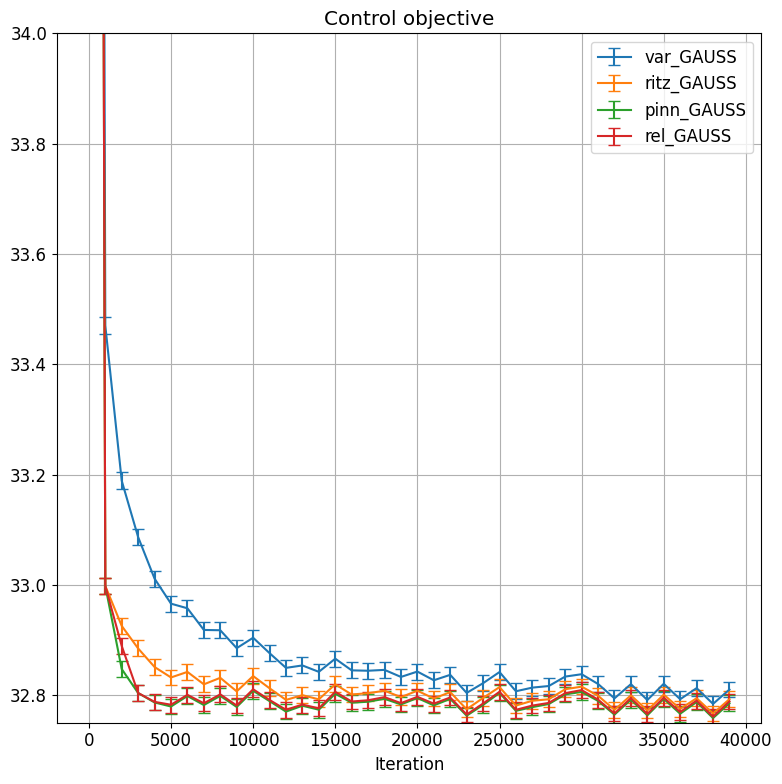

In [9]:
with plt.rc_context({'font.size': 12}):
    fig, ax = plt.subplots(figsize=(8,8))

    index = 'itr'
    col_appendix = ""
    ls = ['-','--','-.']

    for i in range(len(run_names)):
        run_df = df.query(f'run_name=="{run_names[i]}"').copy()
        run_df.drop_duplicates('control_objective_mean',inplace=True)
        run_df.plot(x=index,y='control_objective_mean'+col_appendix, yerr='control_objective_std'+col_appendix, ax = ax, label=f'{run_names[i]}',capsize=4)
        
        ax.set_ylim(32.75,34)
        ax.grid()
        ax.set_xlabel('Time (s)' if index=="time" else "Iteration")
    
    #ax.set_ylim(1e-4,10)
    plt.legend(loc='upper right')
    ax.set_title('Control objective')

    plt.tight_layout()
    plt.show()

### Control error: IDO vs COMBINED

In [10]:
experiment_name = "double_well_d10"
run_names = ['IDO/rel_entropy','IDO/log_variance','IDO/SOCM', 'IDO/SOCM_adjoint',
             'COMBINED/rel_entropy','COMBINED/log_variance','COMBINED/SOCM','COMBINED/SOCM_adjoint']

Error vs iteration

In [11]:
dfs = []
for run_name in run_names:
    df = pd.read_csv(f'experiments/{experiment_name}/{run_name}/logs.csv')
    df.dropna(how='all', inplace=True)
    df['run_name'] = run_name
    df['time'] = df['iteration_time'].cumsum()
    df.ffill(inplace=True)
    dfs.append(df)

df = pd.concat(dfs)

EMA_halflife = 200
for column in df.columns:
    if 'error' in column or 'loss' in column:
        df[f'{column}_EMA'] = (
            df.groupby('run_name')[column]
            .transform(lambda x: np.exp(x.apply(lambda x: np.log(x)).ewm(halflife=EMA_halflife, adjust=False).mean()))
            #.transform(lambda x: x.apply(lambda x: x.ewm(halflife=EMA_halflife, adjust=False).mean()))
        )

print(df.columns)

Index(['itr', 'iteration_time', 'loss', 'control_objective_mean',
       'control_objective_std', 'control_l2_error', 'run_name', 'time',
       'loss_EMA', 'control_l2_error_EMA'],
      dtype='object')


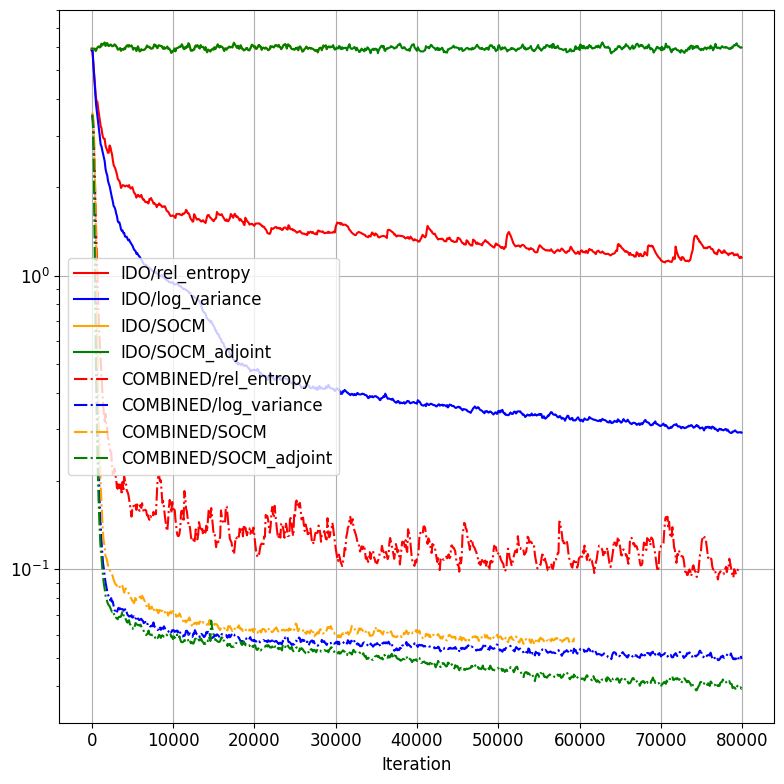

In [12]:
with plt.rc_context({'font.size': 12}):
    fig, ax = plt.subplots(figsize=(8,8))

    index = 'itr'
    col_appendix = "_EMA"
    
    colors = []
    ls = []
    for run_name in run_names:
        if 'IDO' in run_name or 'EIGF' in run_name:
            ls += ['-']
        else:
            ls += ['-.']
        
        if 'variance' in run_name:
            colors += ['blue']
        elif 'rel_entropy' in run_name:
            colors += ['red']
        elif 'SOCM_adjoint' in run_name:
            colors += ['green']
        elif 'SOCM' in run_name:
            colors += ['orange']
        elif 'EIGF' in run_name:
            colors += ['black']


    for i in range(len(run_names)):
        run_df = df.query(f'run_name=="{run_names[i]}"')
        run_df.plot(x=index,y='control_l2_error'+col_appendix, ax = ax, label=f'{run_names[i]}', ls=ls[i],color=colors[i])

        ax.set_yscale('log')
        #ax.set_xscale('log')
        ax.grid()
        ax.set_xlabel('Time (s)' if index=="time" else "Iteration")
    
    #ax.set_ylim(1e-4,10)
    plt.legend()

    plt.tight_layout()
    plt.show()

### Ring visualization

In [13]:
experiment_name = 'ring_d2'
run_names = ['EIGF/pinn_GAUSS', 'EIGF/rel_GAUSS']
solvers = {}
for run_name in run_names:
    cfg = OmegaConf.load(f'experiments/{experiment_name}/{run_name}/cfg.yaml')

    cfg.num_steps=500
    ts = torch.linspace(0, cfg.T, cfg.num_steps + 1).to(cfg.device)

    x0, sigma, optimal_sde, neural_sde = define_variables(cfg, ts)

    state0 = x0.repeat(cfg.optim.batch_size*16, 1)

    solver = SOC_Solver(
            neural_sde,
            x0,
            None,
            T=cfg.T,
            num_steps=cfg.num_steps,
            lmbd=cfg.lmbd,
            d=cfg.d,
            sigma=sigma,
            solver_cfg=cfg.solver
        )

    solver.load_state_dict(torch.load(f'experiments/{experiment_name}/{run_name}/solver_weights_5_000.pth'))
    solvers[run_name] = solver

/tmp/ipykernel_1053009/1290088552.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  solver.load_state_dict(torch.load(f'experiments/{experiment_name}/{run_name}/solver_we

In [14]:
dfs = []
for run_name in run_names:
    df = pd.read_csv(f'experiments/{experiment_name}/{run_name}/logs.csv')
    df.dropna(how='all', inplace=True)
    df['run_name'] = run_name
    df['time'] = df['iteration_time'].cumsum()
    df.ffill(inplace=True)
    dfs.append(df)

df = pd.concat(dfs)

EMA_halflife = 200
for column in df.columns:
    if 'error' in column or 'loss' in column:
        df[f'{column}_EMA'] = (
            df.groupby('run_name')[column]
            #.transform(lambda x: np.exp(x.apply(lambda x: np.log(x)).ewm(halflife=EMA_halflife, adjust=False).mean()))
            .transform(lambda x: x.ewm(halflife=EMA_halflife, adjust=False).mean())
        )

print(df.columns)

labels = {'EIGF/pinn_GAUSS': 'PINN loss',
            'EIGF/rel_GAUSS': 'Relative loss'}

Index(['itr', 'iteration_time', 'loss', 'main_loss', 'orth_loss',
       'control_objective_mean', 'control_objective_std', 'run_name', 'time',
       'loss_EMA', 'main_loss_EMA', 'orth_loss_EMA'],
      dtype='object')


Visualize energy

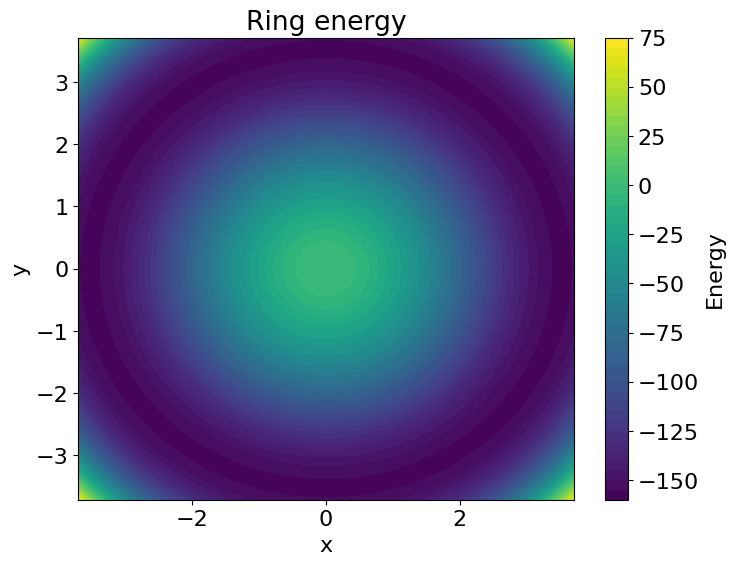

In [15]:
with plt.rc_context({'font.size': 16}):
    radius = neural_sde.radius / np.sqrt(2)
    
    eps = 0.05
    x_range = (-radius*(1+eps),radius*(1+eps))
    y_range = (-radius*(1+eps),radius*(1+eps))

    resolution = 100

    x = torch.linspace(*x_range, resolution)
    y = torch.linspace(*y_range, resolution)
    grid_x, grid_y = torch.meshgrid(x, y, indexing='ij')  # 'ij' indexing ensures consistent axes

    # Flatten the grid for batched evaluation
    grid_points = torch.stack([grid_x.flatten(), grid_y.flatten()], dim=-1)  # Shape: (resolution^2, 2)

    # Evaluate the function on the grid
    grid_z = neural_sde.energy(grid_points.to(neural_sde.device)).cpu()  # Shape: (resolution^2)

    # Reshape the output back to the grid shape
    grid_z = grid_z.view(resolution, resolution)

    # Visualize the function as a heatmap
    plt.figure(figsize=(8, 6))
    plt.contourf(grid_x, grid_y, grid_z, levels=50, cmap='viridis')
    plt.colorbar(label="Energy")
    plt.title("Ring energy")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

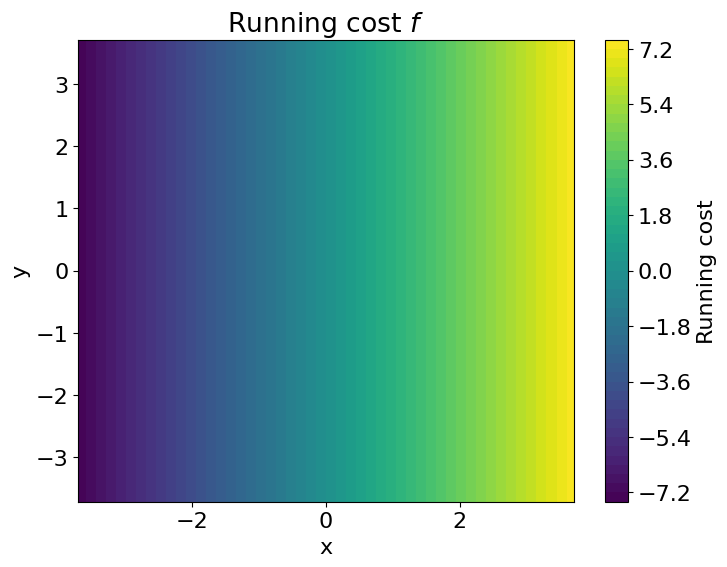

In [16]:
with plt.rc_context({'font.size': 16}):
    radius = neural_sde.radius / np.sqrt(2)
    
    eps = 0.05
    x_range = (-radius*(1+eps),radius*(1+eps))
    y_range = (-radius*(1+eps),radius*(1+eps))

    resolution = 100

    x = torch.linspace(*x_range, resolution)
    y = torch.linspace(*y_range, resolution)
    grid_x, grid_y = torch.meshgrid(x, y, indexing='ij')  # 'ij' indexing ensures consistent axes

    # Flatten the grid for batched evaluation
    grid_points = torch.stack([grid_x.flatten(), grid_y.flatten()], dim=-1)  # Shape: (resolution^2, 2)

    # Evaluate the function on the grid
    grid_z = neural_sde.f(None,grid_points.to(neural_sde.device)).cpu()  # Shape: (resolution^2)

    # Reshape the output back to the grid shape
    grid_z = grid_z.view(resolution, resolution)

    # Visualize the function as a heatmap
    plt.figure(figsize=(8, 6))
    plt.contourf(grid_x, grid_y, grid_z, levels=50, cmap='viridis')
    plt.colorbar(label="Running cost")
    plt.title("Running cost $f$")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

In [17]:
run_df

,itr,iteration_time,loss,control_objective_mean,control_objective_std,control_l2_error,run_name,time,loss_EMA,control_l2_error_EMA
0,0.0,2.070816,0.000530,530.760376,0.247708,3.515182,COMBINED/SOCM_adjoint,2.070816,0.000530,3.515182
1,1.0,0.716946,0.000457,530.760376,0.247708,3.515182,COMBINED/SOCM_adjoint,2.787761,0.000530,3.515182
2,2.0,0.818529,0.000509,530.760376,0.247708,3.515182,COMBINED/SOCM_adjoint,3.606291,0.000530,3.515182
3,3.0,0.788958,0.000382,530.760376,0.247708,3.515182,COMBINED/SOCM_adjoint,4.395248,0.000529,3.515182
4,4.0,0.804313,0.000471,530.760376,0.247708,3.515182,COMBINED/SOCM_adjoint,5.199561,0.000529,3.515182
...,...,...,...,...,...,...,...,...,...,...
79896,79896.0,0.507527,0.000107,39.563812,0.008654,0.038088,COMBINED/SOCM_adjoint,59064.907621,0.000160,0.039216
79897,79897.0,0.553585,0.000498,39.563812,0.008654,0.038088,COMBINED/SOCM_adjoint,59065.461207,0.000160,0.039212
79898,79898.0,0.462914,0.000441,39.563812,0.008654,0.038088,COMBINED/SOCM_adjoint,59065.924121,0.000161,0.039208
79899,79899.0,0.533318,0.000174,39.563812,0.008654,0.038088,COMBINED/SOCM_adjoint,59066.457439,0.000161,0.039204


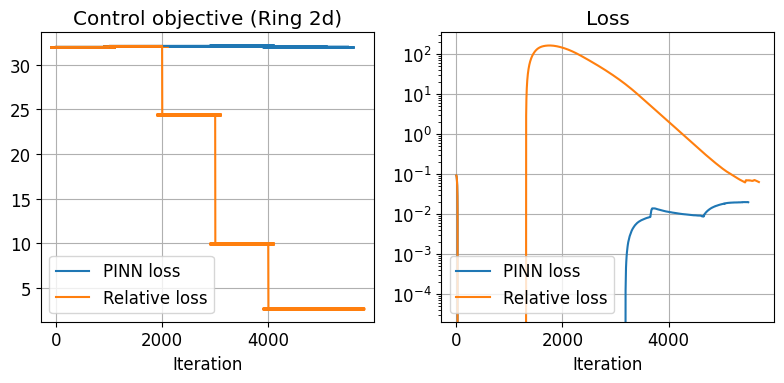

In [18]:
with plt.rc_context({'font.size': 12}):
    fig, ax = plt.subplots(1,2,figsize=(8,4))

    index = 'itr'
    col_appendix = "_EMA"
    colors = []
    ls = []
    for run_name in run_names:
        if 'IDO' in run_name or 'EIGF' in run_name:
            ls += ['-']
        else:
            ls += ['-.']
        
        if 'variance' in run_name:
            colors += ['blue']
        elif 'rel_entropy' in run_name:
            colors += ['red']
        elif 'SOCM_adjoint' in run_name:
            colors += ['green']
        elif 'SOCM' in run_name:
            colors += ['orange']
        elif 'EIGF' in run_name:
            colors += ['black']

    for i in range(len(run_names)):
        run_df = df.query(f'run_name=="{run_names[i]}"').copy()
        #run_df.drop_duplicates('control_objective_mean',inplace=True)
        run_df.plot(x=index,y='control_objective_mean', yerr='control_objective_std', ax = ax[0], label=labels[run_names[i]],capsize=4)
        run_df.plot(x=index,y='loss'+col_appendix, ax = ax[1], label=labels[run_names[i]])

        ax[0].grid()
        ax[0].set_xlabel('Time (s)' if index=="time" else "Iteration")
        ax[1].set_yscale('log')
        ax[1].grid()
        ax[1].set_xlabel('Time (s)' if index=="time" else "Iteration")
    
    plt.legend(loc='lower left')
    ax[0].set_title('Control objective (Ring 2d)')
    ax[1].set_title('Loss')

    plt.tight_layout()
    plt.show()


Visualize control inputs

/home/lclaeys/miniconda3/envs/efs-env/lib/python3.13/site-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


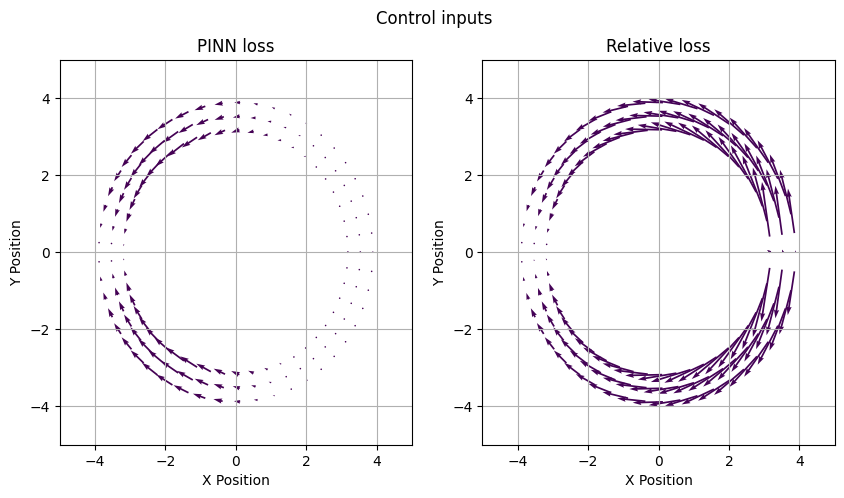

In [19]:
fig, axes = plt.subplots(1,2,figsize=(10,5)) 

colors = ['red','blue']
for j in range(len(run_names)):
    solver = solvers[run_names[j]]
    num = 50
    angles = torch.linspace(0,2*np.pi,num,device=ts.device)
    r_states = []
    n = 3
    rs = torch.linspace(4.5,5.5,n)
    for r in rs:
        r_states.append(r/2**(1/2) * torch.stack([angles.cos(),angles.sin()],dim=1))

    states = torch.concatenate(r_states)
    controls = solver.control(torch.zeros(len(states),device=states.device), states)[:-1,:]
    states= states.unsqueeze(1)
    controls = controls.unsqueeze(1)

    states = states[:-1].cpu().detach()
    controls = controls.cpu().detach()

    i = 0
    dt = (ts[1] - ts[0]).cpu()
    # Extract the first batch for visualization
    x, y = states[:, i, 0], states[:, i, 1]
    u, v = controls[:, i, 0], controls[:, i, 1]

    colors = cm.viridis(np.linspace(0, 1, len(x)))
        
    # Plot control vectors as arrows
    axes[j].quiver(x, y, u, v, angles='xy', scale_units='xy', color=colors[j], alpha=1.0, scale=4.0, label="Controls")

    # Labels and title
    axes[j].set_xlabel("X Position")
    axes[j].set_ylabel("Y Position")
    axes[j].set_title(labels[run_names[j]])

    # Ensure equal aspect ratio
    #ax.set_aspect('equal', adjustable='box')
    axes[j].set_xlim(-5,5)
    axes[j].set_ylim(-5,5)

    #axes[j].legend()
    axes[j].grid()
plt.suptitle('Control inputs')
plt.show()

/home/lclaeys/miniconda3/envs/efs-env/lib/python3.13/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


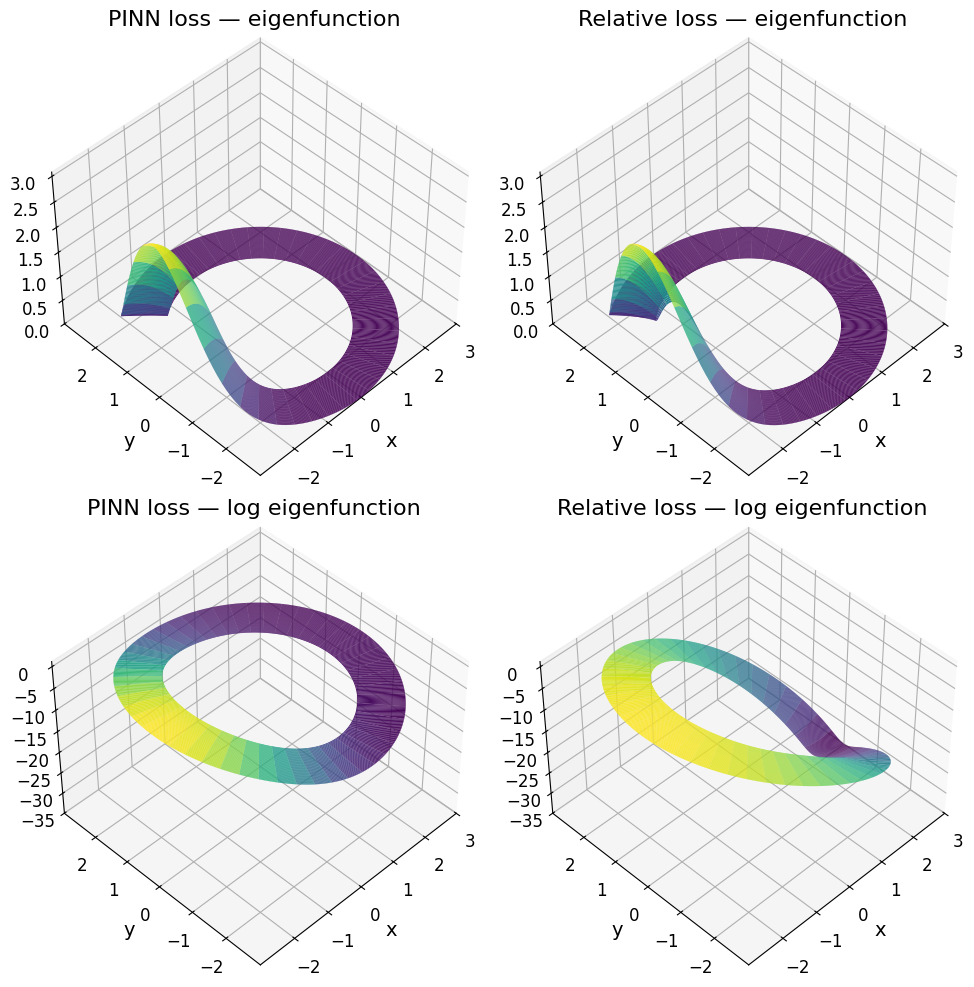

In [20]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Optional: set a global base font size
plt.rcParams['font.size'] = 14

# --- 1) build your common grid in advance ---
r, delta = 2.5, 0.5
n_rho, n_theta = 100, 200

rho = torch.linspace(r - delta, r + delta, n_rho, device=cfg.device)
theta = torch.linspace(0, 2 * np.pi, n_theta, device=cfg.device)
RHO, THETA = torch.meshgrid(rho, theta)

X = RHO * torch.cos(THETA)
Y = RHO * torch.sin(THETA)
XY = torch.stack([X.ravel(), Y.ravel()], dim=1)

X_np = X.cpu().numpy()
Y_np = Y.cpu().numpy()

# --- 2) compute global mins/maxs ---
raw_min, raw_max = float('inf'), float('-inf')
log_min, log_max = float('inf'), float('-inf')

Zs_raw, Zs_log = [], []
for run_name in run_names:
    solver = solvers[run_name]
    f = lambda pts: solver.neural_sde.eigf_gs_model(pts)
    F = (f(XY).reshape(X.shape).detach().cpu().numpy())
    Z_raw = np.exp(F)
    Z_log = F
    Zs_raw.append(Z_raw)
    Zs_log.append(Z_log)
    raw_min, raw_max = min(raw_min, Z_raw.min()), max(raw_max, Z_raw.max())
    log_min, log_max = min(log_min, Z_log.min()), max(log_max, Z_log.max())

# --- 3) plotting with shared limits, bigger fonts, no z‑label ---
n_runs = len(run_names)
fig, axes = plt.subplots(n_runs, 2,
                         subplot_kw={'projection': '3d'},
                         figsize=(10, 5 * n_runs))

if n_runs == 1:
    axes = axes[np.newaxis, :]

for j, run_name in enumerate(run_names):
    ax1, ax2 = axes[0,j], axes[1,j]
    Z_raw, Z_log = Zs_raw[j], Zs_log[j]

    # --- raw eigenfunction ---
    surf1 = ax1.plot_surface(X_np, Y_np, Z_raw, cmap='viridis')
    ax1.set_xlim(X_np.min(), X_np.max())
    ax1.set_ylim(Y_np.min(), Y_np.max())
    ax1.set_zlim(raw_min, raw_max)
    ax1.set_xlabel('x', fontsize=14)
    ax1.set_ylabel('y', fontsize=14)
    # remove or hide z‑axis label
    ax1.zaxis.label.set_visible(False)
    ax1.set_title(f'{labels[run_name]} — eigenfunction', fontsize=16)
    ax1.tick_params(labelsize=12)
    ax1.view_init(elev=45, azim=225)

    # --- log eigenfunction ---
    surf2 = ax2.plot_surface(X_np, Y_np, Z_log, cmap='viridis')
    ax2.set_xlim(X_np.min(), X_np.max())
    ax2.set_ylim(Y_np.min(), Y_np.max())
    ax2.set_zlim(log_min, log_max)
    ax2.set_xlabel('x', fontsize=14)
    ax2.set_ylabel('y', fontsize=14)
    ax2.zaxis.label.set_visible(False)
    ax2.set_title(f'{labels[run_name]} — log eigenfunction', fontsize=16)
    ax2.tick_params(labelsize=12)
    ax2.view_init(elev=45, azim=225)

plt.tight_layout()
plt.show()